# DVS Gesture SNN — 8-bit Post-Training Static Quantization

This notebook demonstrates **PyTorch's built-in post-training static quantization** (`torch.ao.quantization`) applied to a Spiking Neural Network trained on the DVS Gesture dataset.

**Workflow:**
1. Load pre-trained float32 SNN weights from `snn.pth`
2. Evaluate float32 baseline accuracy
3. Create a quantization-aware wrapper with proper QuantStub/DeQuantStub boundaries
4. Calibrate observers on training data
5. Convert to INT8 quantized model
6. Evaluate and compare model sizes

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.ao.quantization
import numpy as np
import os

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import tonic
import tonic.transforms as transforms

import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"Note: Quantized inference will run on CPU (PyTorch quantization backend requirement)")

Device: cpu
Note: Quantized inference will run on CPU (PyTorch quantization backend requirement)


In [3]:
# Dataset Parameters
sensor_size = tonic.datasets.DVSGesture.sensor_size
transform = transforms.Compose([
    transforms.ToFrame(sensor_size=sensor_size, n_time_bins=15), 
])

train_set = tonic.datasets.DVSGesture(save_to='./data', train=True, transform=transform)
test_set = tonic.datasets.DVSGesture(save_to='./data', train=False, transform=transform)

cached_dataloader_args = {
    "batch_size": 16,
    "collate_fn": tonic.collation.PadTensors(batch_first=False),
    "shuffle": True,
    "num_workers": 0 
}

train_loader = DataLoader(train_set, **cached_dataloader_args)
test_loader = DataLoader(test_set, **cached_dataloader_args)

# Inspect Data
data, targets = next(iter(train_loader))
print(f"Data shape: {data.shape}")

Data shape: torch.Size([15, 16, 2, 128, 128])


## Step 1: Define the SNN and Load Pre-trained Weights from `snn.pth`

In [4]:
# Neuron Parameters
beta = 0.5
spike_grad = surrogate.atan()

class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()

        # Layer 1: Conv -> Pool -> LIF
        self.conv1 = nn.Conv2d(2, 16, kernel_size=5, stride=2, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)

        # Layer 2: Conv -> Pool -> LIF
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)

        # Output Layer: FC -> LIF
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 11)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.lif1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.lif2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        spk_out, mem_out = self.lif3(x)

        return spk_out, mem_out

net = SNN().to(device)
print(net)

SNN(
  (conv1): Conv2d(2, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lif1): Leaky()
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lif2): Leaky()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=11, bias=True)
  (lif3): Leaky()
)


In [5]:
# Load pre-trained float32 weights from snn.pth
net.load_state_dict(torch.load('snn.pth', map_location=device))
net.eval()
print(f"Loaded pre-trained weights from snn.pth")
print(f"Float model size: {os.path.getsize('snn.pth') / 1024:.1f} KB")

Loaded pre-trained weights from snn.pth
Float model size: 146.9 KB


## Step 2: Evaluate the Float32 Model (Baseline)

In [6]:
print("Evaluating Float32 Model (Baseline)...")
net.eval()

total = 0
correct = 0

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        utils.reset(net)
        spk_rec = []

        for step in range(data.size(0)):
            spk_out, mem_out = net(data[step])
            spk_rec.append(spk_out)

        spk_rec = torch.stack(spk_rec)
        acc = SF.accuracy_rate(spk_rec, targets)
        correct += acc * data.size(1) 
        total += data.size(1)

float_acc = correct / total
print(f"Float32 Test Accuracy: {float_acc*100:.2f}%")

Evaluating Float32 Model (Baseline)...
Float32 Test Accuracy: 76.14%


## Step 3: Define the Quantizable SNN Wrapper

PyTorch's eager-mode quantization requires `QuantStub` and `DeQuantStub` to mark the boundaries between quantized (INT8) and floating-point regions of the model.

**Important:** Each stub instance must only be used **once** in the forward pass. Since LIF neurons maintain float state variables, we dequantize before each LIF and re-quantize after.

In [7]:
class QuantizableSNN(nn.Module):
    """SNN with proper QuantStub/DeQuantStub boundaries for 8-bit quantization.
    
    Each QuantStub/DeQuantStub is a separate instance because PyTorch
    attaches unique observers to each stub. Reusing stubs causes incorrect
    quantization parameters.
    """
    def __init__(self):
        super(QuantizableSNN, self).__init__()

        # --- Quantization Stubs (one per boundary) ---
        self.quant_input = torch.ao.quantization.QuantStub()   # float input -> int8
        self.dequant1 = torch.ao.quantization.DeQuantStub()    # int8 -> float (before LIF1)
        self.quant2 = torch.ao.quantization.QuantStub()        # float -> int8 (after LIF1)
        self.dequant2 = torch.ao.quantization.DeQuantStub()    # int8 -> float (before LIF2)
        self.quant3 = torch.ao.quantization.QuantStub()        # float -> int8 (after LIF2)
        self.dequant3 = torch.ao.quantization.DeQuantStub()    # int8 -> float (before LIF3)

        # --- Layer 1 ---
        self.conv1 = nn.Conv2d(2, 16, kernel_size=5, stride=2, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)

        # --- Layer 2 ---
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)

        # --- Output Layer ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 11)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

    def forward(self, x):
        # Quantize input: float32 -> int8
        x = self.quant_input(x)

        # Layer 1: Conv + Pool in INT8
        x = self.conv1(x)
        x = self.pool1(x)
        # Dequantize for LIF (needs float state)
        x = self.dequant1(x)
        x = self.lif1(x)

        # Re-quantize for Layer 2
        x = self.quant2(x)
        # Layer 2: Conv + Pool in INT8
        x = self.conv2(x)
        x = self.pool2(x)
        # Dequantize for LIF
        x = self.dequant2(x)
        x = self.lif2(x)

        # Re-quantize for FC layer
        x = self.quant3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        # Dequantize for output LIF
        x = self.dequant3(x)
        spk_out, mem_out = self.lif3(x)

        return spk_out, mem_out

print("QuantizableSNN defined.")

QuantizableSNN defined.


## Step 4: Post-Training Static Quantization Pipeline

1. **Load** pre-trained float weights from `snn.pth` into the quantizable wrapper
2. **Set qconfig** — specifies the 8-bit quantization scheme (observers + quantization ops)
3. **Prepare** — inserts observers to collect activation statistics
4. **Calibrate** — runs representative data through the model to compute scale/zero-point
5. **Convert** — replaces float ops with quantized INT8 ops

In [8]:
# 1. Create quantizable model and load pre-trained float weights from snn.pth
qnet = QuantizableSNN()
qnet.load_state_dict(torch.load('snn.pth', map_location='cpu'), strict=False)
qnet.eval()  # Must be in eval mode for static quantization
qnet.to('cpu')  # Quantization runs on CPU

# 2. Set the quantization config (8-bit weights + 8-bit activations)
# 'x86' backend works on most x86 CPUs. Use 'fbgemm' for server CPUs.
qnet.qconfig = torch.ao.quantization.get_default_qconfig('x86')
print(f"QConfig: {qnet.qconfig}")

# 3. Prepare: insert observers to track activation ranges
torch.ao.quantization.prepare(qnet, inplace=True)
print("\nModel prepared with observers. Ready for calibration.")

# 4. Calibrate: run representative data through the model
print("\nCalibrating on training data subset...")
num_calib_batches = 10  # Use ~10 batches for calibration
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(train_loader):
        if batch_idx >= num_calib_batches:
            break
        data = data.to('cpu')
        utils.reset(qnet)
        for step in range(data.size(0)):
            qnet(data[step])  # Forward pass collects statistics
        print(f"  Calibration batch {batch_idx+1}/{num_calib_batches}")

# 5. Convert: replace float operations with quantized INT8 operations
torch.ao.quantization.convert(qnet, inplace=True)
print("\n=== Quantization Complete ===")
print("\nQuantized Model Architecture:")
print(qnet)

QConfig: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

Model prepared with observers. Ready for calibration.

Calibrating on training data subset...


c:\Users\dhruv\miniconda3\envs\jupyter_env\lib\site-packages\torch\ao\quantization\observer.py:244: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


  Calibration batch 1/10
  Calibration batch 2/10
  Calibration batch 3/10
  Calibration batch 4/10
  Calibration batch 5/10
  Calibration batch 6/10
  Calibration batch 7/10
  Calibration batch 8/10
  Calibration batch 9/10
  Calibration batch 10/10

=== Quantization Complete ===

Quantized Model Architecture:
QuantizableSNN(
  (quant_input): Quantize(scale=tensor([0.5195]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant1): DeQuantize()
  (quant2): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant2): DeQuantize()
  (quant3): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant3): DeQuantize()
  (conv1): QuantizedConv2d(2, 16, kernel_size=(5, 5), stride=(2, 2), scale=5.527625560760498, zero_point=65, padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lif1): Leaky()
  (conv2): QuantizedConv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), scale=1.51522958278

## Step 5: Evaluate the Quantized INT8 Model

In [9]:
print("Evaluating Quantized INT8 Model...")
qnet.eval()

total = 0
correct = 0

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to('cpu')  # Quantized models run on CPU
        targets = targets.to('cpu')
        
        utils.reset(qnet)
        spk_rec = []

        for step in range(data.size(0)):
            spk_out, mem_out = qnet(data[step])
            spk_rec.append(spk_out)

        spk_rec = torch.stack(spk_rec)
        acc = SF.accuracy_rate(spk_rec, targets)
        correct += acc * data.size(1) 
        total += data.size(1)

quant_acc = correct / total
print(f"Quantized INT8 Test Accuracy: {quant_acc*100:.2f}%")

Evaluating Quantized INT8 Model...
Quantized INT8 Test Accuracy: 79.17%


## Step 6: Compare Float32 vs INT8 Quantized Model

         Model Comparison: Float32 vs INT8
Metric                         Float32         INT8
-------------------------------------------------------
Model Size (KB)                  146.9         47.9
Test Accuracy (%)                76.14        79.17
Accuracy Drop (%)                    —        -3.03
Compression Ratio                 1.0x         3.1x


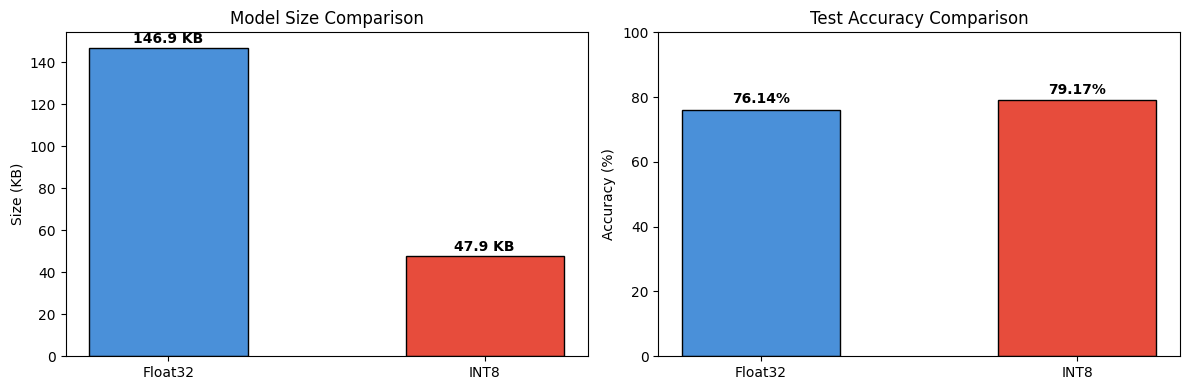

In [10]:
# Save quantized model
torch.save(qnet.state_dict(), 'snn_quantized_int8.pth')

# Compare sizes
float_size = os.path.getsize('snn.pth') / 1024
quant_size = os.path.getsize('snn_quantized_int8.pth') / 1024
compression = float_size / quant_size

print("=" * 55)
print("         Model Comparison: Float32 vs INT8")
print("=" * 55)
print(f"{'Metric':<25} {'Float32':>12} {'INT8':>12}")
print("-" * 55)
print(f"{'Model Size (KB)':<25} {float_size:>12.1f} {quant_size:>12.1f}")
print(f"{'Test Accuracy (%)':<25} {float_acc*100:>12.2f} {quant_acc*100:>12.2f}")
print(f"{'Accuracy Drop (%)':<25} {'—':>12} {(float_acc - quant_acc)*100:>12.2f}")
print(f"{'Compression Ratio':<25} {'1.0x':>12} {compression:>11.1f}x")
print("=" * 55)

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Model Size Bar Chart
bars = ax1.bar(['Float32', 'INT8'], [float_size, quant_size], 
               color=['#4A90D9', '#E74C3C'], width=0.5, edgecolor='black')
ax1.set_ylabel('Size (KB)')
ax1.set_title('Model Size Comparison')
for bar, val in zip(bars, [float_size, quant_size]):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
             f'{val:.1f} KB', ha='center', va='bottom', fontweight='bold')

# Accuracy Bar Chart
bars2 = ax2.bar(['Float32', 'INT8'], [float_acc*100, quant_acc*100], 
                color=['#4A90D9', '#E74C3C'], width=0.5, edgecolor='black')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy Comparison')
ax2.set_ylim(0, 100)
for bar, val in zip(bars2, [float_acc*100, quant_acc*100]):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
             f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Step 7: Inspect Quantized Layer Details

Verify that Conv2d and Linear layers have been converted to their quantized counterparts with INT8 scale and zero-point parameters.

In [11]:
print("=== Quantized Layer Details ===")
print()

for name, module in qnet.named_modules():
    if hasattr(module, 'weight') and hasattr(module.weight(), 'qscheme'):
        w = module.weight()
        print(f"Layer: {name}")
        print(f"  Type: {type(module).__name__}")
        print(f"  Weight dtype: {w.dtype}")
        print(f"  Weight qscheme: {w.qscheme()}")
        print(f"  Weight scale shape: {w.q_per_channel_scales().shape if w.qscheme() == torch.per_channel_affine else 'per_tensor'}")
        print(f"  Weight range: [{w.int_repr().min().item()}, {w.int_repr().max().item()}]")
        print()

=== Quantized Layer Details ===

Layer: conv1
  Type: Conv2d
  Weight dtype: torch.qint8
  Weight qscheme: torch.per_channel_affine
  Weight scale shape: torch.Size([16])
  Weight range: [-128, 127]

Layer: conv2
  Type: Conv2d
  Weight dtype: torch.qint8
  Weight qscheme: torch.per_channel_affine
  Weight scale shape: torch.Size([32])
  Weight range: [-128, 127]

Layer: fc1
  Type: Linear
  Weight dtype: torch.qint8
  Weight qscheme: torch.per_channel_affine
  Weight scale shape: torch.Size([11])
  Weight range: [-128, 96]

